In [12]:
import numpy as np
from generate_burgers import generate_control_sequence, generate_initial_y, burgers_update, roughness, visualize_state_trajectory

In [4]:
def get_trajectory(
        y0,
        nt = 500, # Number of time steps
        dt= 0.001, # Temporal interval
        nx = 128, # Number of spatial nodes (grid points)
        dx = 10/128, # Spatial interval
        ):
    '''
    Generate a single trajectory of the Burgers equation.

    nx: number of spatial nodes (state dim)
    nt: number of time steps
    dx: spatial interval
    dt: temporal interval
    y0: (state_dim,), initial state vector
    '''
    y_list = [] # Holds states from y_0 to y_{nt}
    u_list = [] # Holds control sequence u_0 to u_{nt-1}
    
    y = y0 # Set the initial state
    y_list.append(y) # Append the initial state to Y_bar

    for t_idx in range(nt): # Iterate over time steps
        u=generate_control_sequence(y,t_idx*dt) # (n,), Control vector at time t_idx*dt
        y_new=burgers_update(y, u, dx, dt) # (n,), Updated state vector at time t_idx*dt
        u_list.append(u) # u_{t_idx}
        y_list.append(y_new) # y_bar_{t_idx+1}
        y=y_new # Update y
    
    # Set the observations, actions, and final state
    state_trajectory=np.stack(y_list[:-1]) # (nt, state_dim), States from y_0 to y_{nt-1}
    final_state=y # (state_dim,), Final state y_{nt}
    action_trajectory=(np.stack(u_list)) # (nt, state_dim), Control sequence from u_0 to u_{nt-1}
    
    # Set timeout flag
    timeouts = np.zeros(nt, dtype=bool) # (nt,)
    timeouts[-1] = True # Set the last time step as timeout
    
    # Set terminal flag
    terminals = np.zeros(nt, dtype=bool) # (nt,)
    for t_idx in range(nt): # Iterate over time steps
        if roughness(state_trajectory[t_idx])/dx > 10: # If the roughness is so large that the average first derivative among all spatial nodes is greater that 10, set it as terminal
            terminals[t_idx:] = True # Set all subsequent time steps as terminal
            break
    
    rewards = np.zeros(nt) # (nt,)
    if True in terminals: # If the trajectory diverges (terminates early)
        terminal_timestep=list(terminals).index(True) # Get the index of the first terminal time step
        roughness_turn_timestep=None # The last time step at which the roughness turns from going smaller to going larger
        for t_idx in reversed(range(1, terminal_timestep)): # Iterate over time steps
            if roughness(state_trajectory[t_idx+1])/dx < \
                    roughness(state_trajectory[t_idx])/dx: # Find the last time step at which the roughness turns from going smaller to going larger
                final_state=state_trajectory[t_idx] # (n,); The final state is reset to this time step
                roughness_turn_timestep=t_idx # The roughness turn time step is set to this time step
                break
        rewards[:roughness_turn_timestep] = \
            -((state_trajectory[:roughness_turn_timestep] - final_state)**2).mean(axis=-1) / \
            (final_state**2).mean() # The rewards before the terminal time step are set as the negative L2 distance between the final state and the current state
        rewards[roughness_turn_timestep:] = -np.inf # The rewards after the terminal time step are set as -inf
    else:
        rewards = \
            -((state_trajectory - final_state)**2).mean(axis=-1) / \
            (final_state**2).mean() # If the trajectory converges (doesn't terminate early), set the reward as the negative L2 distance between the final state and the current state
    
    return state_trajectory, action_trajectory, final_state, timeouts, terminals, rewards

In [16]:
x_range = (-5,5)
nx=128
dx = (x_range[1]-x_range[0])/nx # Spatial interval
dt = 0.01 # Time interval
nt = 400
x = np.linspace(*x_range, nx) # Initialize the spatial grid
y = generate_initial_y(x) # Set the initial condition
n = nx # state dimension. In this case, the state is all function values at the spatial grid points, so n=nx.
y0=generate_initial_y(x)
state_trajectory, action_trajectory, final_state, timeouts, terminals, rewards=get_trajectory(y0)

In [9]:
print(state_trajectory.shape)
print(action_trajectory.shape)
print(rewards.shape)

(500, 128)
(500, 128)
(500,)


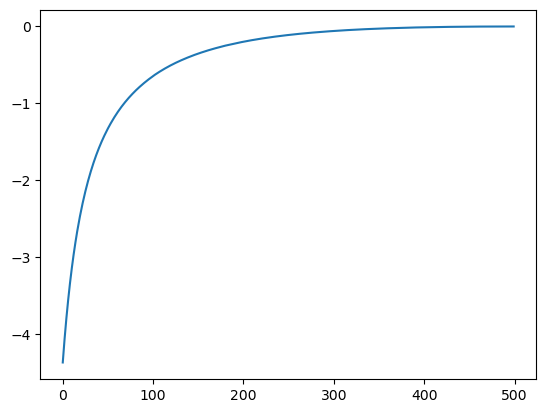

In [11]:
import matplotlib.pyplot as plt
plt.plot(rewards)

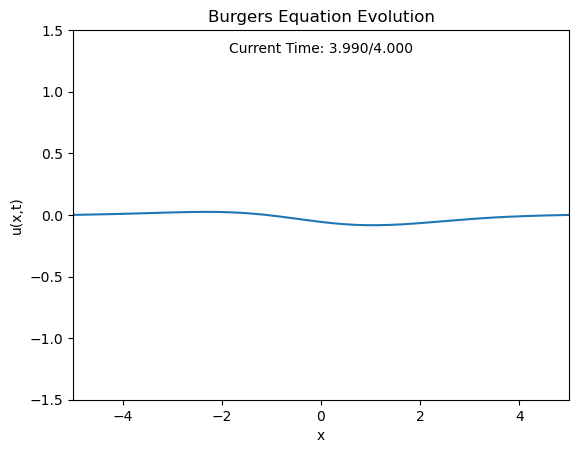

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
def visualize_state_trajectory(x, Y, dt, nt):
    """
    Visualize the state trajectories of a sample.

    :param x: (nx,), the spatial grid.
    :param Y: (T-1, nx), the state trajectories.
    :param dt: the temporal interval.
    :param nt: the number of time steps.
    """
    from matplotlib.animation import FuncAnimation
    # Set up the figure and axis for plotting
    fig, ax = plt.subplots()
    line, = ax.plot(x, Y[0], label="Burgers equation solution")
    ax.set_ylim(-1.5, 1.5)
    ax.set_xlim(x.min(), x.max())
    ax.set_title("Burgers Equation Evolution")
    ax.set_xlabel("x")
    ax.set_ylabel("u(x,t)")
    time_text = ax.text(0.5, 0.95, "",
                        transform=ax.transAxes,
                        horizontalalignment='center',
                        verticalalignment='center')

    # Animation update function
    def update(frame):
        line.set_ydata(Y[frame])
        time_text.set_text(f'Current Time: {frame * dt:.3f}/{nt*dt:.3f}')  # 更新时间提示
        return line, time_text

    # Create the animation
    ani = FuncAnimation(fig, update, frames=nt, blit=True, interval=50)
    HTML(ani.to_jshtml())
visualize_state_trajectory(x, state_trajectory, dt, nt)